In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

# Standard imports
import os 
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
# Ionpy imports
from ionpy.analysis import ResultsLoader
# Local imports
from ese.analysis.analyze_inf import load_cal_inference_stats

sns.set_style("darkgrid")
sns.set_context("talk")
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root:
        - '/storage/vbutoi/scratch/ESE/inference/10_29_24_OCTA_FULLRES_Updated_Benchmark'
        - '/storage/vbutoi/scratch/ESE/inference/10_26_24_ISLES_Benchmark'
        - '/storage/vbutoi/scratch/ESE/inference/10_28_24_WMH_AllHospitals_Benchmark'
    inference_group: 
        - 'Base'
        - 'Optimal_RAVE_Threshold'
        - 'Optimal_RAVE_Temperature'

options:
    verify_graceful_exit: True
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

# Plotting Calls

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False
)

/storage/vbutoi/scratch/ESE/inference/10_25_24_ISLES_Benchmark/Base                                     20241025_123807-G6CJ-6f785215c8e2bcbcd2d22786766acd50    150
                                                                                                        20241025_123811-823B-6b9fb24ea9c19fe9cb54abc7c9283bc5    150
/storage/vbutoi/scratch/ESE/inference/10_26_24_ISLES_Benchmark/Optimal_RAVE_Temperature                 20241026_121856-YEBX-b1f17304cbbd314fdf1f4ff66168e380    150
                                                                                                        20241026_121900-2RCI-bccd184cb21db2efdfc3133c38c946a3    150
/storage/vbutoi/scratch/ESE/inference/10_26_24_ISLES_Benchmark/Optimal_RAVE_Threshold                   20241029_153534-G4OF-e28a7f5e5a913d07b9f25f5e875a2794    150
                                                                                                        20241029_153539-5QGF-82a930d0678255c873339e19725cdd33    150
/storage/v

In [4]:
# for ikey in inference_df.keys():
#     print(ikey)

In [5]:
inference_df['inference_data_class'].unique()

array(['ese.datasets.OCTA_6M', 'ese.datasets.ISLES', 'ese.datasets.WMH'],
      dtype=object)

In [6]:
def method_group(log_root):
    suffix = log_root.split('/')[-1]
    if "Base" in suffix:
        return "Base"
    elif "Threshold" in suffix:
        return "Threshold Tuned Hard"
    elif "Temperature" in suffix:
        return "Temperature Tuned Soft"
    else:
        raise ValueError("Unknown method")

def pred_volume(method_group, hard_volume, soft_volume):
    if method_group == "Threshold Tuned Hard": 
        return hard_volume
    elif method_group == "Temperature Tuned Soft":
        return soft_volume
    else:
        return None

def dataset(inference_data_class):
    return inference_data_class.split('.')[-1]

inference_df.augment(dataset)
inference_df.augment(method_group)
inference_df.augment(pred_volume)

In [7]:
# Get the rows corresponding to the base methods, and drop them frm the dataframe
base_rows = inference_df[inference_df['method_group'] == 'Base']
tuned_df = inference_df[inference_df['method_group'] != 'Base'].copy()

# Now we duplicate the base_rows.
hard_thresh_df = base_rows.copy()
hard_thresh_df['pred_volume'] = hard_thresh_df['hard_volume']
hard_thresh_df['method_group'] = 'Base Hard'

soft_thresh_df = base_rows.copy()
soft_thresh_df['pred_volume'] = soft_thresh_df['soft_volume']
soft_thresh_df['method_group'] = 'Base Soft'

# Concatenate the new rows to the dataframe
methods_df = pd.concat([tuned_df, hard_thresh_df, soft_thresh_df])

In [8]:
# Assert that there are no NaNs in pred_volume or gt_volume
assert not methods_df['pred_volume'].isna().any()
assert not methods_df['gt_volume'].isna().any()

In [9]:
def VE(pred_volume, gt_volume):
    return np.abs(pred_volume - gt_volume)

def RVE(pred_volume, gt_volume):
    return (pred_volume - gt_volume) / gt_volume

def RAVE(pred_volume, gt_volume):
    return np.abs(pred_volume - gt_volume) / gt_volume

def log_VE(VE):
    log_soft_err = np.log(VE + 1)
    # if the error is negative infinity, we will return -2.
    if log_soft_err == -np.inf:
        return -3
    else:
        return log_soft_err

def loss_func(loss_func_class):
    if loss_func_class == "ese.losses.PixelCELoss":
        return "CrossEntropy"
    elif loss_func_class == "ese.losses.SoftDiceLoss":
        return "SoftDice"
    else:
        raise ValueError("Unknown loss function")

methods_df.augment(loss_func)
methods_df.augment(VE)
methods_df.augment(RVE)
methods_df.augment(RAVE)
methods_df.augment(log_VE)

In [10]:
# Only keep the rows where the image_metric is 'Dice'
methods_df = methods_df[methods_df['image_metric'] == 'Dice']
# Rename the column metric score for this new df to Dice
methods_df = methods_df.rename(columns={'metric_score': 'Dice'})

In [11]:
# We need to prune the df to the cols we care about
cols_to_keep = [
    "pred_volume",
    "gt_volume",
    "Dice",
    "VE",
    "RVE",
    "log_VE",
    "RAVE",
    "loss_func",
    "dataset",
    "split",
    "data_id",
    "method_group"
]
# Prune the dataframe
analyis_df = methods_df[cols_to_keep].drop_duplicates().reset_index(drop=True)

In [12]:
analyis_df

,pred_volume,gt_volume,Dice,VE,RVE,log_VE,RAVE,loss_func,dataset,split,data_id,method_group
0,14228.000000,14289.0,0.731353,61.000000,-0.004269,4.127134,0.004269,CrossEntropy,OCTA_6M,cal,subject_10186.bmp,Threshold Tuned Hard
1,19077.000000,17183.0,0.731605,1894.000000,0.110225,7.546974,0.110225,CrossEntropy,OCTA_6M,cal,subject_10148.bmp,Threshold Tuned Hard
2,13755.000000,14167.0,0.700380,412.000000,-0.029082,6.023448,0.029082,CrossEntropy,OCTA_6M,cal,subject_10188.bmp,Threshold Tuned Hard
3,18229.000000,18822.0,0.773906,593.000000,-0.031506,6.386879,0.031506,CrossEntropy,OCTA_6M,cal,subject_10021.bmp,Threshold Tuned Hard
4,14775.000000,13708.0,0.689113,1067.000000,0.077838,6.973543,0.077838,CrossEntropy,OCTA_6M,cal,subject_10127.bmp,Threshold Tuned Hard
...,...,...,...,...,...,...,...,...,...,...,...,...
1731,17159.011719,20444.0,0.879807,3284.988281,-0.160682,8.097423,0.160682,CrossEntropy,WMH,val,Singapore_62,Base Soft
1732,1737.779541,1345.0,0.754717,392.779541,0.292029,5.975791,0.292029,CrossEntropy,WMH,val,Utrecht_33,Base Soft
1733,1157.048340,1005.0,0.696567,152.048340,0.151292,5.030754,0.151292,CrossEntropy,WMH,val,Amsterdam_110,Base Soft
1734,1274.746460,1109.0,0.678590,165.746460,0.149456,5.116474,0.149456,CrossEntropy,WMH,val,Amsterdam_139,Base Soft


# Look at Method Performance

In [13]:
val_analyis_df = analyis_df[analyis_df['split'] == 'val'].copy()

In [14]:
# These are the unique values of the estimator column.
val_analyis_df['method_group'] = val_analyis_df['method_group'].astype('category')
val_analyis_df['method_group'] = val_analyis_df['method_group'].cat.reorder_categories([
    'Base Hard',
    'Base Soft',
    'Threshold Tuned Hard',
    'Temperature Tuned Soft'
])

Text(0.5, 0.98, 'Relative Absolute Volumetric Error (RAVE) by Method, Loss Function, and Dataset')

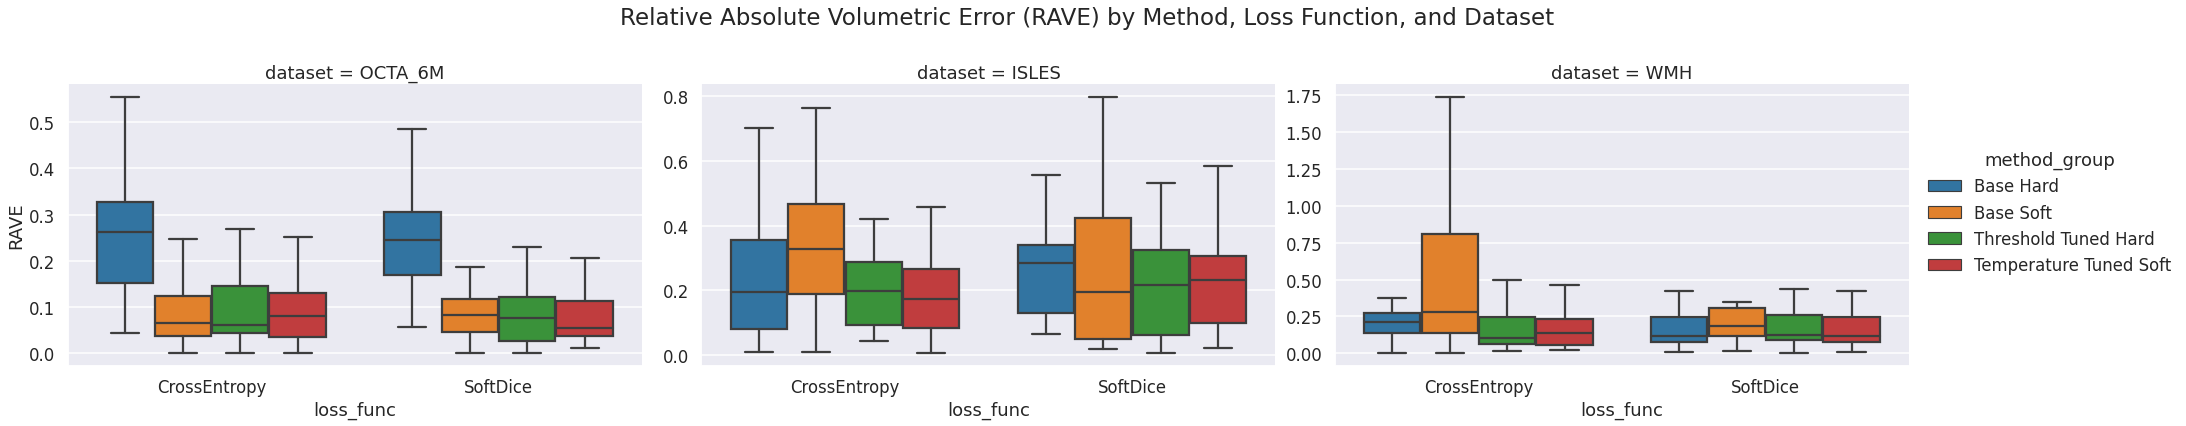

In [15]:
g = sns.catplot(
    val_analyis_df, 
    x='loss_func', 
    y='RAVE', 
    hue='method_group', 
    kind='box',
    col='dataset',
    aspect=1.5,
    height=6,
    showfliers=False,
    sharey=False
)
# We want to make a title for the plot, with some spacing 
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle(f"Relative Absolute Volumetric Error (RAVE) by Method, Loss Function, and Dataset", fontsize=23)

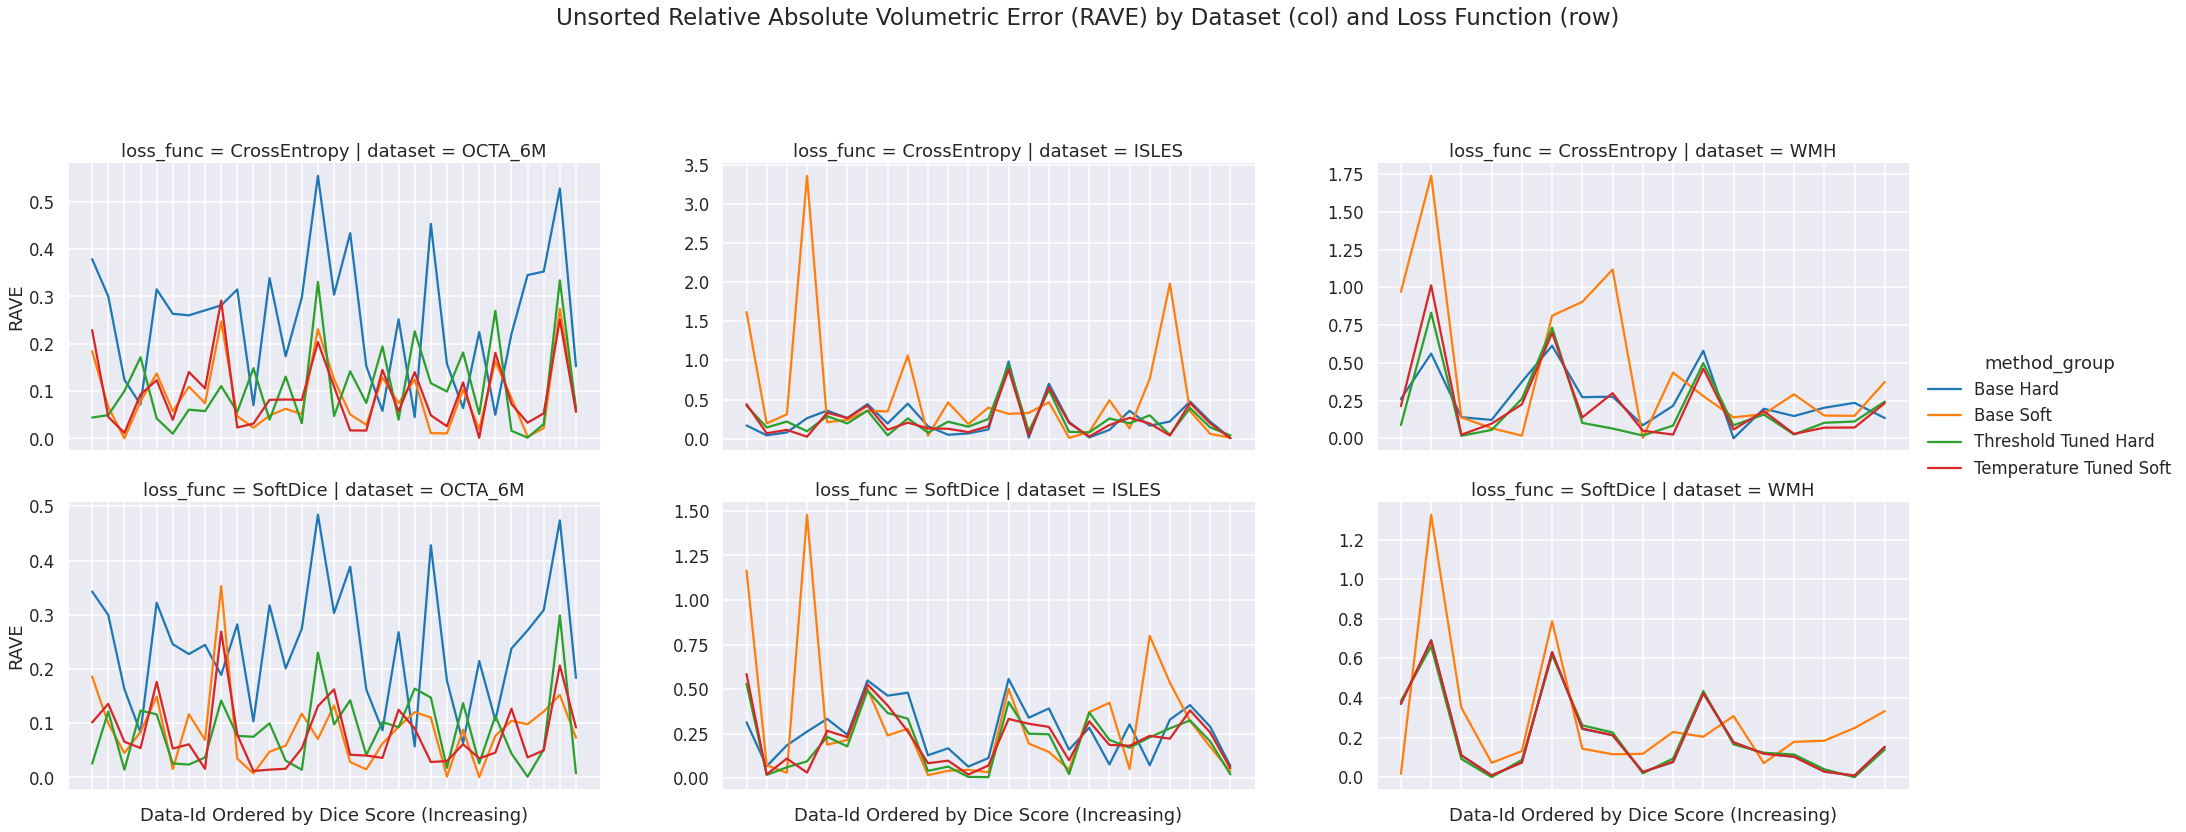

In [16]:
g = sns.relplot(
    val_analyis_df,
    x='data_id', 
    y='RAVE', 
    hue='method_group', 
    kind='line',
    col='dataset',
    row='loss_func',
    aspect=1.5,
    height=6,
    facet_kws={'sharex': False, 'sharey': False}
)
# Disable x tick labels
g.set(xticklabels=[])
g.set_axis_labels("Data-Id Ordered by Dice Score (Increasing)", "RAVE")
# We want to make a title for the plot, with some spacing 
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle(f"Unsorted Relative Absolute Volumetric Error (RAVE) by Dataset (col) and Loss Function (row)", fontsize=23)
plt.show()

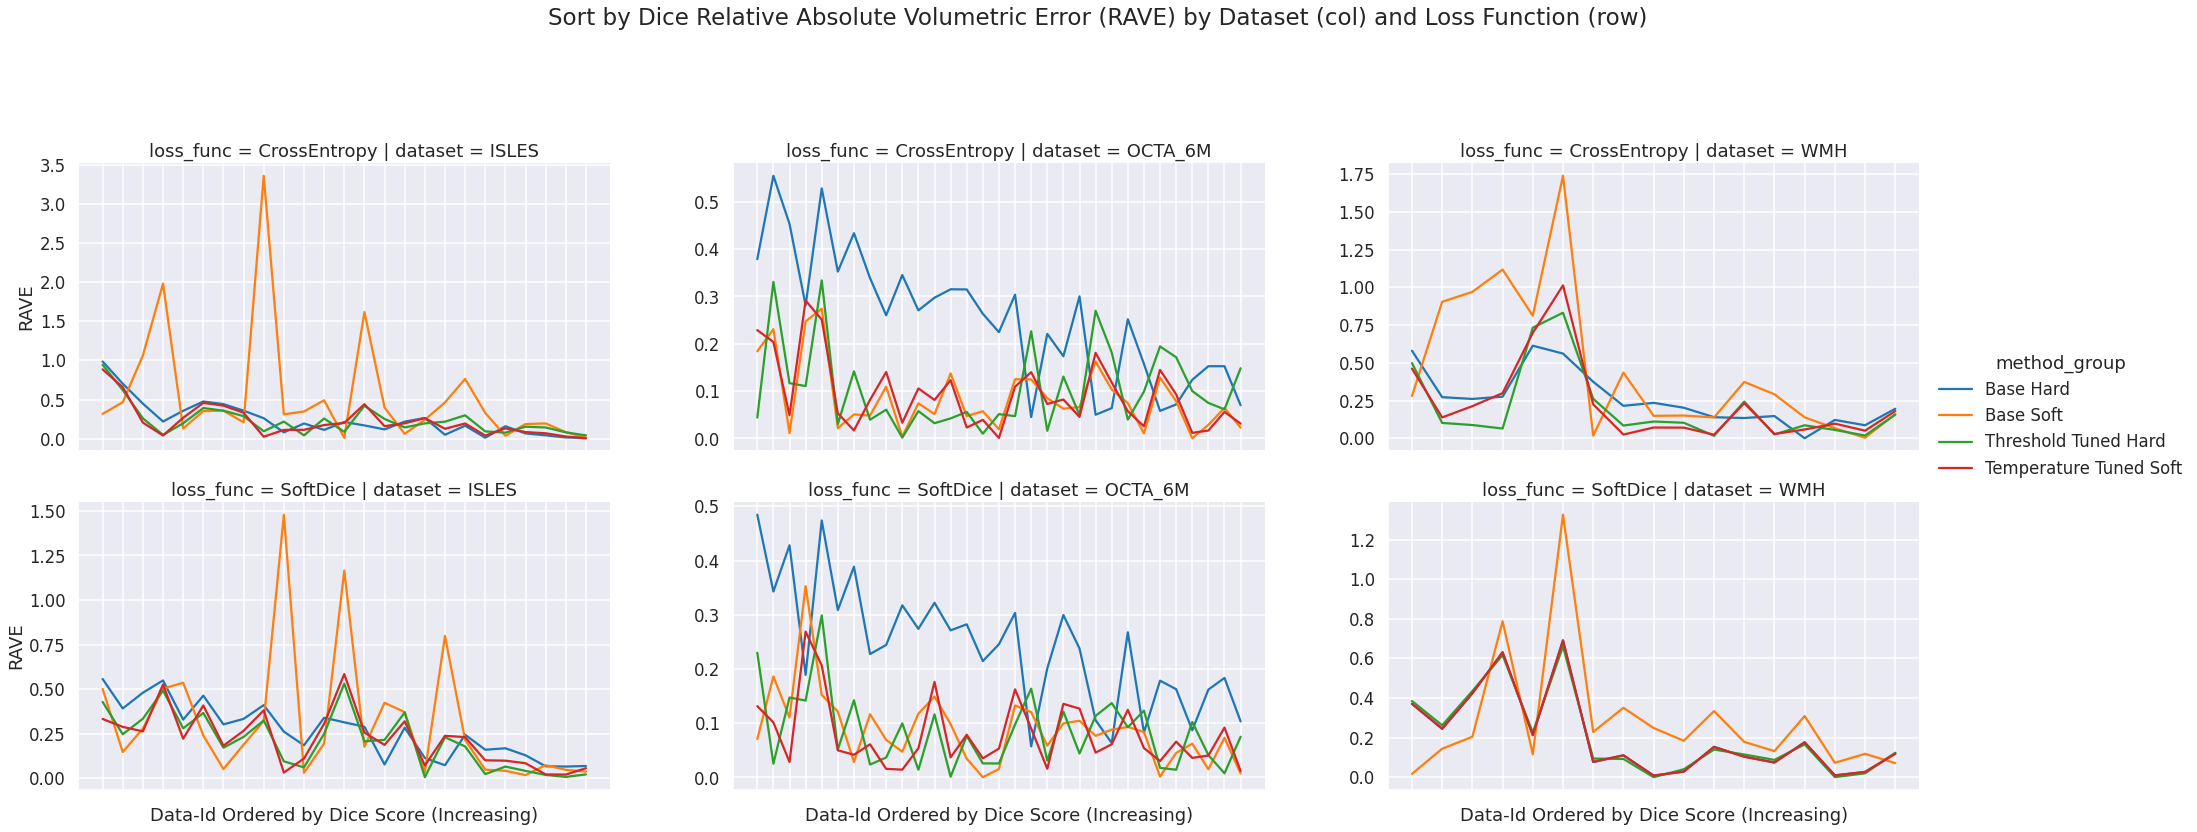

In [17]:
# Sort by Dice Score
vad_sortby_dice = val_analyis_df.sort_values(by='Dice', ascending=True)

g = sns.relplot(
    vad_sortby_dice,
    x='data_id', 
    y='RAVE', 
    hue='method_group', 
    kind='line',
    col='dataset',
    row='loss_func',
    aspect=1.5,
    height=6,
    facet_kws={'sharex': False, 'sharey': False}
)
# Disable x tick labels
g.set(xticklabels=[])
g.set_axis_labels("Data-Id Ordered by Dice Score (Increasing)", "RAVE")
# We want to make a title for the plot, with some spacing 
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle(f"Sort by Dice Relative Absolute Volumetric Error (RAVE) by Dataset (col) and Loss Function (row)", fontsize=23)
plt.show()

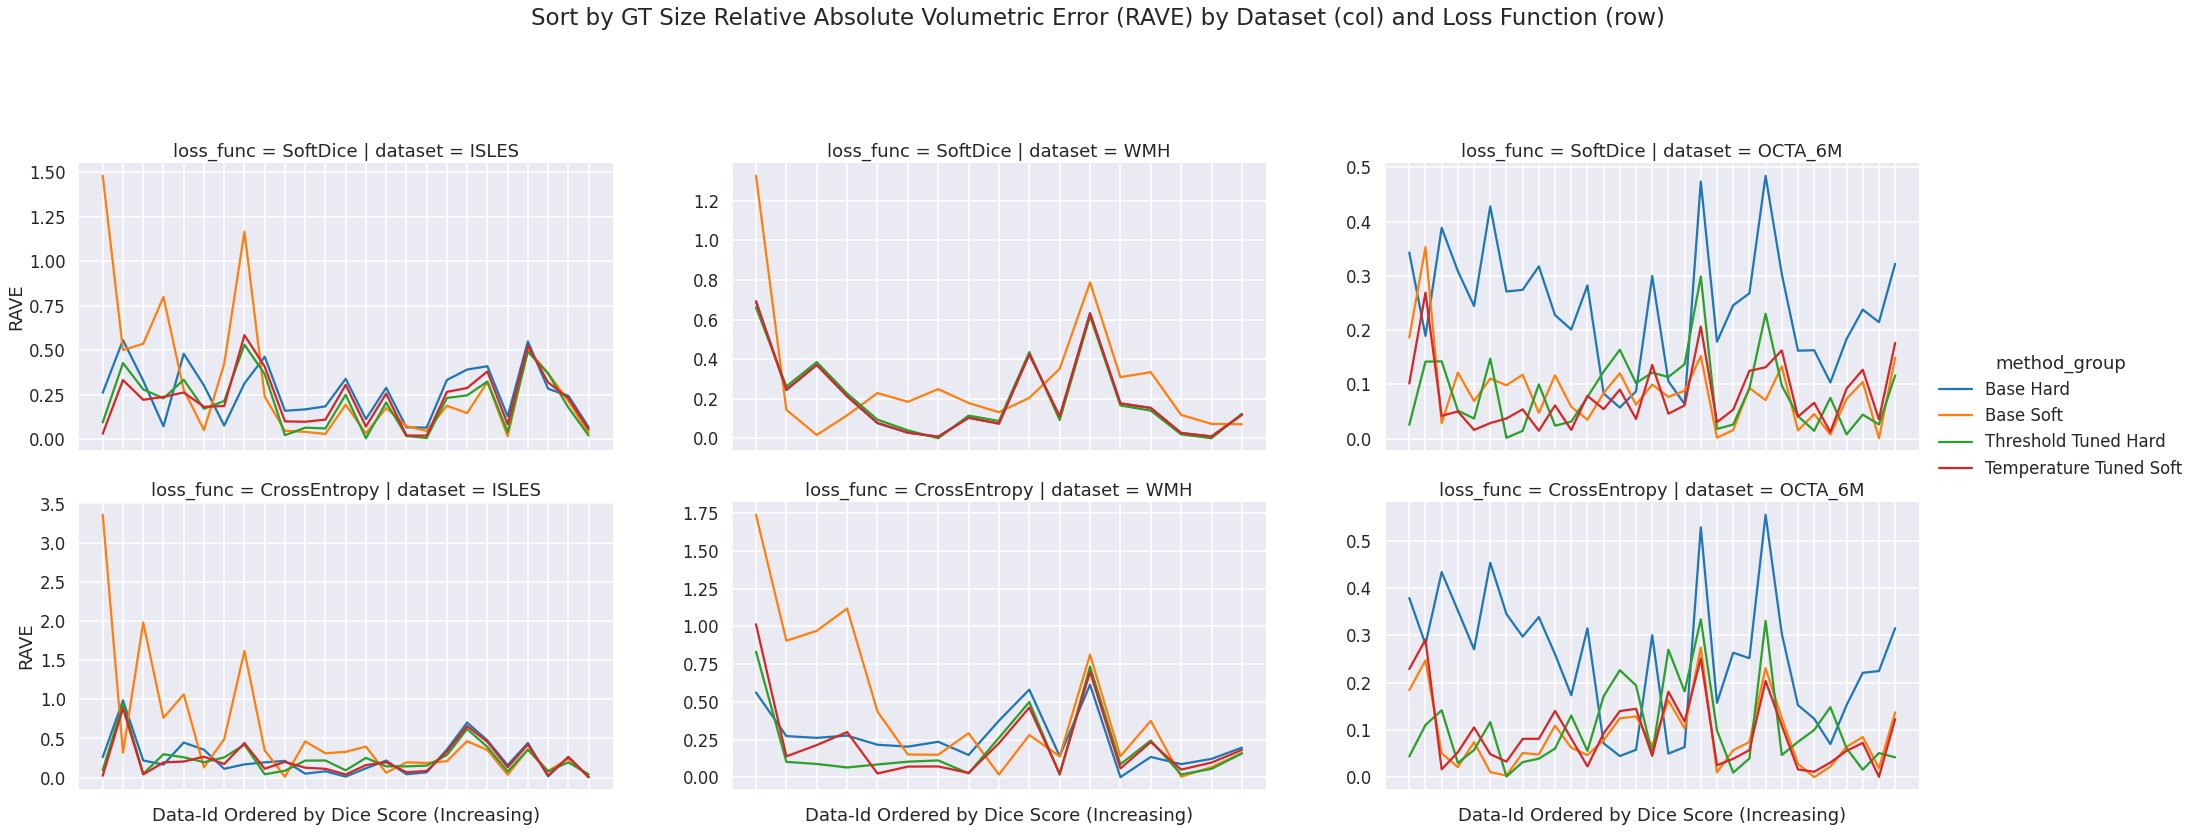

In [18]:
# Sort by Dice Score
vad_sortby_gtvol = val_analyis_df.sort_values(by='gt_volume', ascending=True)

g = sns.relplot(
    vad_sortby_gtvol,
    x='data_id', 
    y='RAVE', 
    hue='method_group', 
    kind='line',
    col='dataset',
    row='loss_func',
    aspect=1.5,
    height=6,
    facet_kws={'sharex': False, 'sharey': False}
)
# Disable x tick labels
g.set(xticklabels=[])
g.set_axis_labels("Data-Id Ordered by Dice Score (Increasing)", "RAVE")
# We want to make a title for the plot, with some spacing 
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle(f"Sort by GT Size Relative Absolute Volumetric Error (RAVE) by Dataset (col) and Loss Function (row)", fontsize=23)
plt.show()

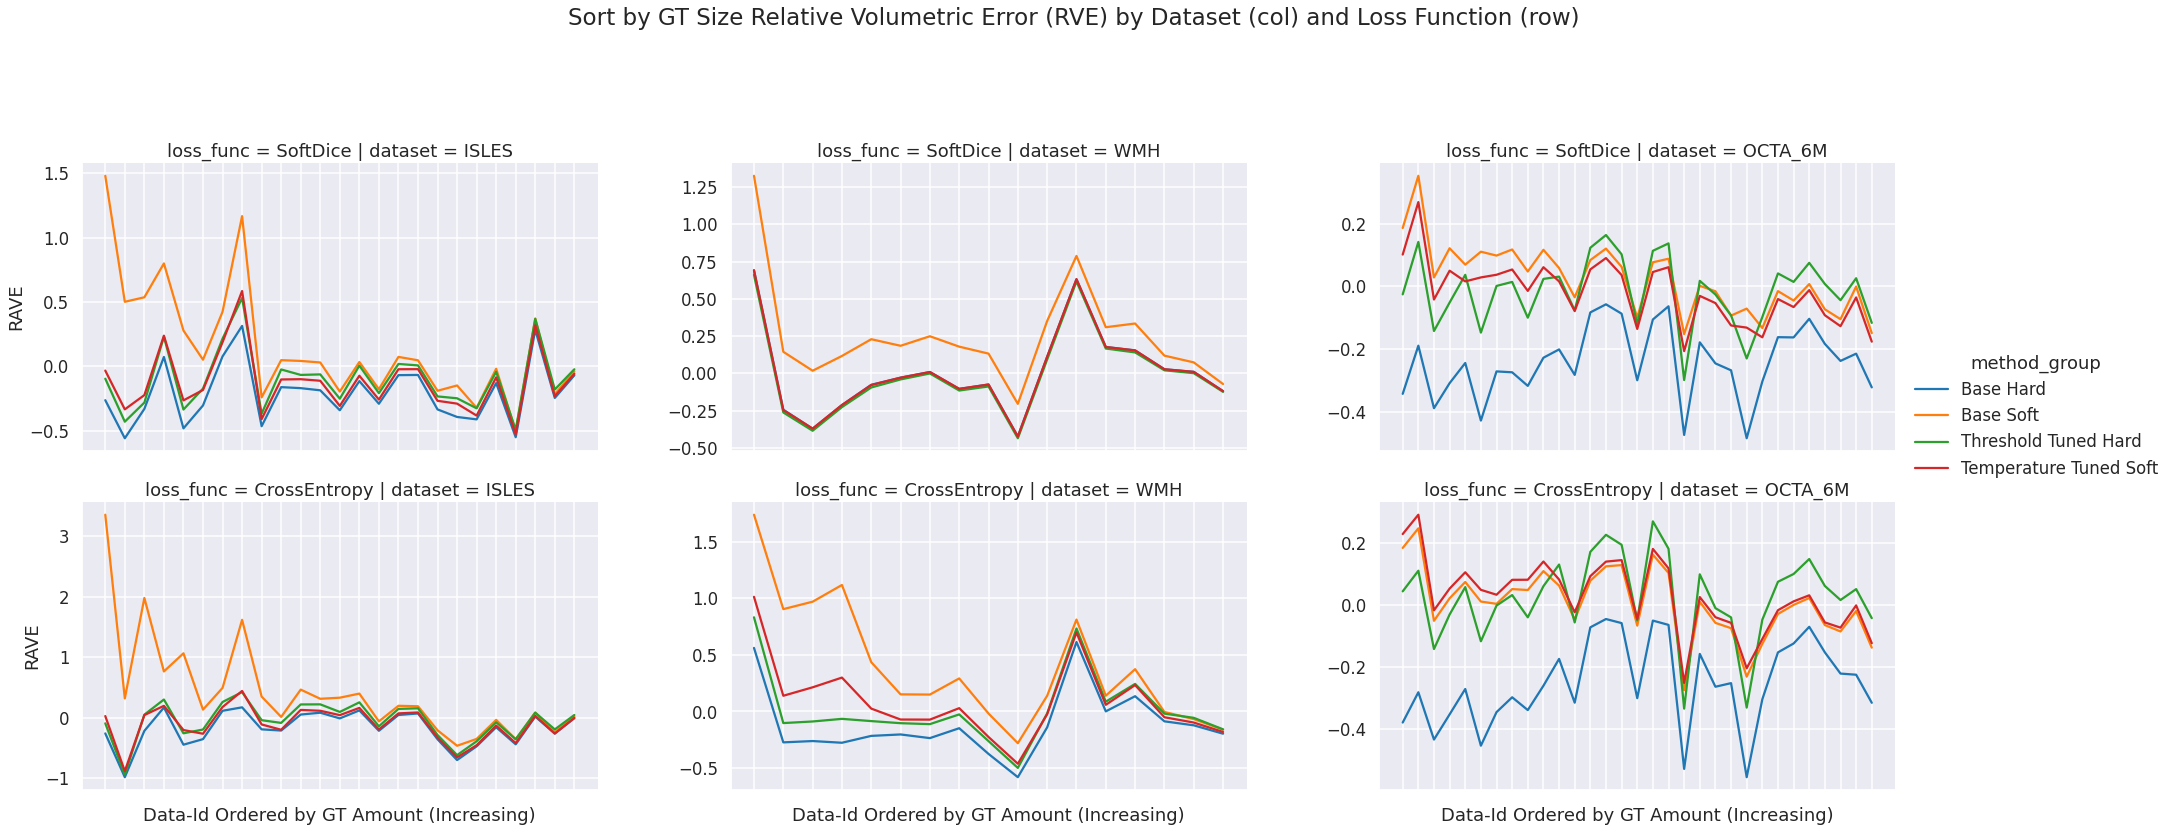

In [41]:
# Sort by Dice Score
vad_sortby_gtvol = val_analyis_df.sort_values(by='gt_volume', ascending=True)

g = sns.relplot(
    vad_sortby_gtvol,
    x='data_id', 
    y='RVE', 
    hue='method_group', 
    kind='line',
    col='dataset',
    row='loss_func',
    aspect=1.5,
    height=6,
    facet_kws={'sharex': False, 'sharey': False}
)
# Disable x tick labels
g.set(xticklabels=[])
g.set_axis_labels("Data-Id Ordered by GT Amount (Increasing)", "RAVE")
# We want to make a title for the plot, with some spacing 
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle(f"Sort by GT Size Relative Volumetric Error (RVE) by Dataset (col) and Loss Function (row)", fontsize=23)
plt.show()

# Investigating what's so bad

In [39]:
vad_sortby_gtvol[vad_sortby_gtvol['loss_func'] == 'SoftDice'].head(12)

,pred_volume,gt_volume,Dice,VE,RVE,log_VE,RAVE,loss_func,dataset,split,data_id,method_group
1103,31.000000,42.0,0.767123,11.000000,-0.261905,2.484907,0.261905,SoftDice,ISLES,val,sub-strokecase0064,Base Hard
492,38.000000,42.0,0.875000,4.000000,-0.095238,1.609438,0.095238,SoftDice,ISLES,val,sub-strokecase0064,Threshold Tuned Hard
567,40.646523,42.0,0.767123,1.353477,-0.032226,0.855894,0.032226,SoftDice,ISLES,val,sub-strokecase0064,Temperature Tuned Soft
1537,104.110291,42.0,0.767123,62.110291,1.478816,4.144884,1.478816,SoftDice,ISLES,val,sub-strokecase0064,Base Soft
577,46.692154,70.0,0.178218,23.307846,-0.332969,3.190799,0.332969,SoftDice,ISLES,val,sub-strokecase0139,Temperature Tuned Soft
1547,105.093056,70.0,0.178218,35.093056,0.501329,3.586100,0.501329,SoftDice,ISLES,val,sub-strokecase0139,Base Soft
502,40.000000,70.0,0.200000,30.000000,-0.428571,3.433987,0.428571,SoftDice,ISLES,val,sub-strokecase0139,Threshold Tuned Hard
1113,31.000000,70.0,0.178218,39.000000,-0.557143,3.688879,0.557143,SoftDice,ISLES,val,sub-strokecase0139,Base Hard
1121,55.000000,82.0,0.627737,27.000000,-0.329268,3.332205,0.329268,SoftDice,ISLES,val,sub-strokecase0080,Base Hard
510,59.000000,82.0,0.638298,23.000000,-0.280488,3.178054,0.280488,SoftDice,ISLES,val,sub-strokecase0080,Threshold Tuned Hard


In [40]:
vad_sortby_gtvol[vad_sortby_gtvol['loss_func'] == 'CrossEntropy'].head(12)

,pred_volume,gt_volume,Dice,VE,RVE,log_VE,RAVE,loss_func,dataset,split,data_id,method_group
642,43.070053,42.0,7.671233e-01,1.070053,0.025477,0.727574,0.025477,CrossEntropy,ISLES,val,sub-strokecase0064,Temperature Tuned Soft
1612,182.979431,42.0,7.671233e-01,140.979431,3.356653,4.955682,3.356653,CrossEntropy,ISLES,val,sub-strokecase0064,Base Soft
417,38.000000,42.0,7.500000e-01,4.000000,-0.095238,1.609438,0.095238,CrossEntropy,ISLES,val,sub-strokecase0064,Threshold Tuned Hard
1178,31.000000,42.0,7.671233e-01,11.000000,-0.261905,2.484907,0.261905,CrossEntropy,ISLES,val,sub-strokecase0064,Base Hard
1622,92.212196,70.0,1.408451e-09,22.212196,0.317317,3.144678,0.317317,CrossEntropy,ISLES,val,sub-strokecase0139,Base Soft
427,4.000000,70.0,2.702703e-02,66.000000,-0.942857,4.204693,0.942857,CrossEntropy,ISLES,val,sub-strokecase0139,Threshold Tuned Hard
652,7.998213,70.0,1.408451e-09,62.001787,-0.885740,4.143163,0.885740,CrossEntropy,ISLES,val,sub-strokecase0139,Temperature Tuned Soft
1188,1.000000,70.0,1.408451e-09,69.000000,-0.985714,4.248495,0.985714,CrossEntropy,ISLES,val,sub-strokecase0139,Base Hard
660,85.395737,82.0,6.575342e-01,3.395737,0.041411,1.480635,0.041411,CrossEntropy,ISLES,val,sub-strokecase0080,Temperature Tuned Soft
435,86.000000,82.0,6.309524e-01,4.000000,0.048780,1.609438,0.048780,CrossEntropy,ISLES,val,sub-strokecase0080,Threshold Tuned Hard


In [20]:
# Get the mean gt_volume by dataset
gt_volume_means = val_analyis_df.groupby('dataset')['gt_volume'].mean()

In [21]:
gt_volume_means

dataset
ISLES       2046.400000
OCTA_6M    14626.354839
WMH         4295.882353
Name: gt_volume, dtype: float64

In [22]:
# set per row the 'mean gt_volume' for that row's dataset
val_analyis_df['mean_gt_volume'] = val_analyis_df['dataset'].map(gt_volume_means)

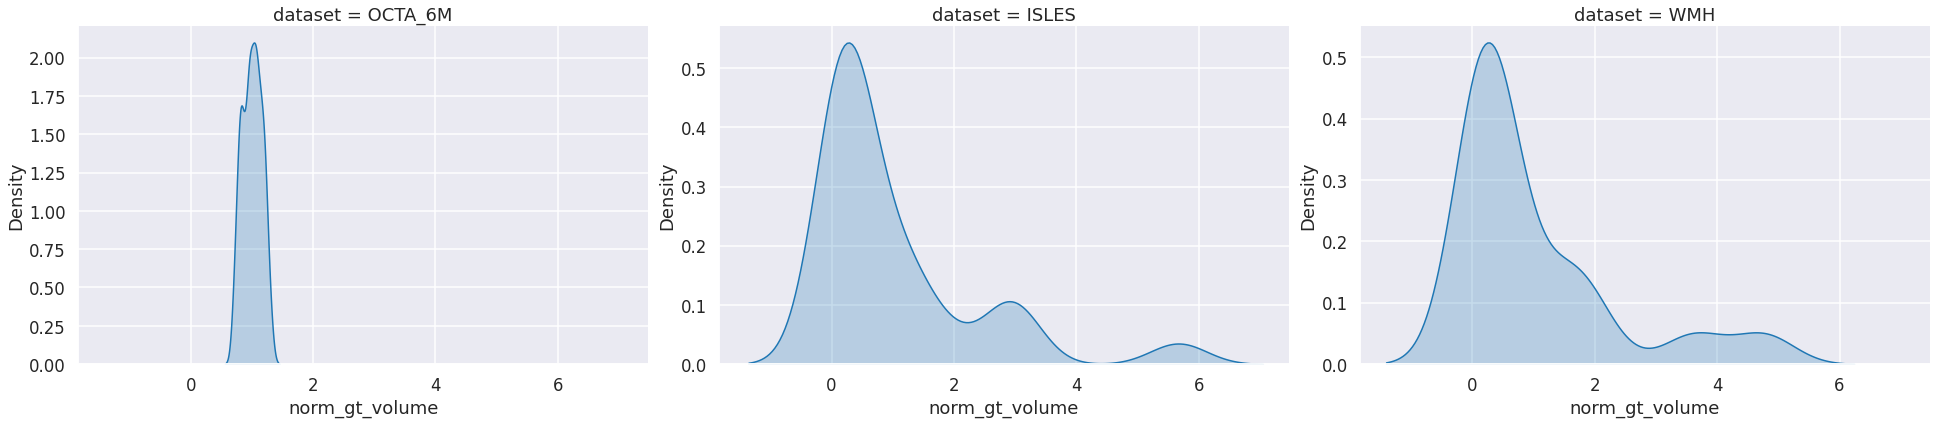

In [23]:
# We want to visualize the distribution of ground truth volumes by dataset, noramlized by the mean
def norm_gt_volume(gt_volume, mean_gt_volume):
    return gt_volume / mean_gt_volume

val_analyis_df.augment(norm_gt_volume)

# Visualize using KDE plos in a facet grid
g = sns.FacetGrid(
    val_analyis_df, 
    col='dataset', 
    aspect=1.5, 
    height=6, 
    sharey=False
)
g.map(sns.kdeplot, 'norm_gt_volume', fill=True)